In [1]:
import numpy as np, os
np.set_printoptions(suppress=True)

import tensorflow as tf 
from tensorflow import keras as tfk

import matplotlib as mpl 
from matplotlib import pyplot as plt
%matplotlib inline

(17621,)
(9710,) (7621,)


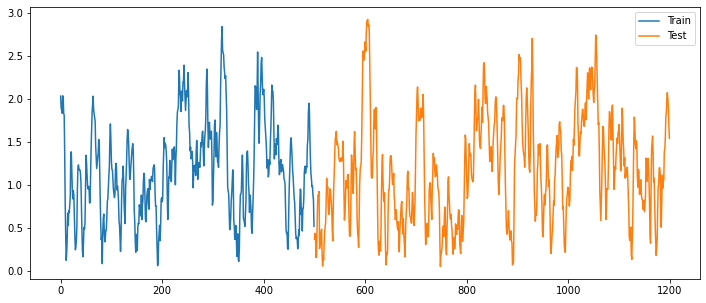

In [8]:
data = {}
entire_data = np.load('amplitude_data.npy')
print(entire_data.shape)
data['train'] = entire_data[:10000]
data['test'] = entire_data[10000:]
idx = np.where(data['train'] > 1e34)[0]
data['train'] = np.delete(data['train'], idx)
print(data['train'].shape, data['test'].shape)

N_train = 500
N_forecast = 700
Ztrain = data['train'][:N_train] 
Ztest = data['train'][N_train:N_train+N_forecast]
# data['train'] = np.load(f'{datadir}/amplitude_data.npy').T
# data['test'] = np.load(f'{datadir}/Z500_Test_Snapshots.npy').T

plt.figure(figsize=(12, 5))
plt.plot(np.arange(N_train), Ztrain)
plt.plot(np.arange(N_train, N_train+N_forecast), Ztest)
plt.legend(['Train', 'Test'])

In [9]:
from itertools import chain, combinations_with_replacement as combinations_w_r

class Features:
    def __init__(self):
        pass

class BiasFeature(Features):
    @property
    def num_bases(self):
        return 1

    def __call__(self, X):
        N = tf.shape(X)[0]
        return tf.expand_dims(tf.ones(N), axis=1)

class PolyFeatures(Features):
    """
    Calculate polynomial features.
    """
    def _combinations(self, n_features=1, min_degree=1, max_degree=2):
        comb = combinations_w_r
        start = max(1, min_degree)
        iter = chain.from_iterable(
            comb(range(n_features), i) for i in range(start, max_degree + 1)
        )
        return iter
    
    def __init__(self, dim=1, max_degree=1):
        #assert max_degree > 0
        super().__init__()
        self.max_degree = max_degree
        self.dim = dim
        self.combs = list(self._combinations(n_features=self.dim, max_degree=self.max_degree))
    
    @property
    def num_bases(self):
        return len(self.combs)

    def __call__(self, X):
        if len(tf.shape(X)) == 1:
            X = tf.expand_dims(X, axis=0)
        d = X.shape[1]
        assert d == self.dim

        xs = tf.unstack(X, axis=-1)  ## x1, x2, ..., xn of shapes (N,)
        features = []
        for comb in self.combs:
            _features = []
            for idx in comb:
                _features.append(xs[idx])
            _features = tf.stack(_features, axis=-1)
            _features = tf.reduce_prod(_features, axis=-1)
            features.append(_features)
        features = tf.stack(features, axis=-1)
        return features

class FourierFeatures(Features):
    def __init__(self, dim=1, n_frequencies=1, include_sine=True, include_cosine=True, lengthscale=1.):
        super().__init__()
        self.n_frequencies = n_frequencies 
        self.include_sine = include_sine 
        self.include_cosine = include_cosine
        self.dim = dim
        self.lengthscale = lengthscale
    
    @property
    def num_bases(self):
        n = 0 
        if self.include_cosine:
            n = self.n_frequencies 
        if self.include_sine:
            n += self.n_frequencies
        return n*self.dim
    
    def __call__(self, X):
        if len(tf.shape(X)) == 1:
            X = tf.expand_dims(X, axis=0)
        d = X.shape[1]

        features = []
        for i in range(1, self.n_frequencies+1):
            if self.include_sine:
                sine_feature = tf.math.sin((2*np.pi*i*X)/self.lengthscale) 
                features.append(sine_feature)
            if self.include_cosine:
                cosine_feature = tf.math.cos((2*np.pi*i*X)/self.lengthscale)
                features.append(cosine_feature)
        return tf.concat(features, axis=-1)

class FourierDense(tfk.layers.Dense):
    def __init__(self, n_frequencies=1, use_bias=False, *args, **kwargs):
        super(FourierDense, self).__init__(1, *args, **kwargs)
        self.n_frequencies = n_frequencies 
        self.use_bias = use_bias 
    
    def build(self, input_shape):
        in_units = input_shape[-1]
        self.featurizer = FourierFeatures(dim=in_units, n_frequencies=self.n_frequencies)

        # set up the parameters
        self.kernel = self.add_weight(
                                shape=(self.featurizer.num_bases, in_units),
                                initializer=self.kernel_initializer,
                                dtype=self.dtype,
                                name="weights",
                                regularizer=self.kernel_regularizer,
                                trainable=True,
                                constraint=self.kernel_constraint,
                                    )
        
        # set up bias 
        if self.use_bias:
            self.bias = self.add_weight(
                                shape=(in_units,),
                                initializer=self.bias_initializer,
                                dtype=self.dtype,
                                name="bias",
                                regularizer=self.bias_regularizer,
                                trainable=True,
                                constraint=self.bias_constraint,
                                    )
        
        else:
            self.bias = tf.zeros((in_units,), dtype=self.dtype)
        self.built=True
    
    def call(self, x):
        features = self.featurizer(x)
        res = tf.matmul(features, self.kernel) + self.bias
        return res



class PolynomialDense(tfk.layers.Dense):
    def __init__(self, max_poly_degree=2, *args, **kwargs):
        super(PolynomialDense, self).__init__(1, *args, **kwargs)
        self.max_poly_degree = max_poly_degree
    
    def build(self, input_shape):
        in_units = input_shape[-1]
        
        # set up the polynomial feature generator 
        self.featurizer = PolyFeatures(dim=in_units, max_degree=self.max_poly_degree)

        # set up the parameters
        if self.featurizer.num_bases > 0:
            self.kernel = self.add_weight(
                                    shape=(self.featurizer.num_bases, in_units),
                                    initializer=self.kernel_initializer,
                                    dtype=self.dtype,
                                    name="weights",
                                    regularizer=self.kernel_regularizer,
                                    trainable=True,
                                    constraint=self.kernel_constraint,
                                        )
        
        # set up bias 
        if self.use_bias:
            self.bias = self.add_weight(
                                shape=(in_units,),
                                initializer=self.bias_initializer,
                                dtype=self.dtype,
                                name="bias",
                                regularizer=self.bias_regularizer,
                                trainable=True,
                                constraint=self.bias_constraint,
                                    )
        else:
            self.bias = tf.zeros((in_units,), dtype=self.dtype)
        self.built=True
    
    def call(self, x):
        features = self.featurizer(x)
        return tf.matmul(features, self.kernel) + self.bias

class NormalScaler:
    def __init__(self, data):
        self.mean = tf.reduce_mean(data, axis=0).numpy()
        self.std = tf.math.reduce_std(data, axis=0).numpy()
    
    def transform(self, x):
        return (x-self.mean) / self.std
    
    def inverse_transform(self, y):
        return self.mean + y*self.std

In [12]:
class GLMDense(tfk.layers.Dense):
    def __init__(self, features=[], **kwargs):
        
        assert len(features) > 0 
        assert all([isinstance(f, Features) for f in features])
        self.features = features
        units = np.sum([phi.num_bases for phi in self.features]) + 1 # 1 for the bias term
        super().__init__(units=units, **kwargs)
    
    def build(self, input_shape):
        in_dims = input_shape[-1] 
        
        self.kernel = self.add_weight(
                                    shape=(self.units, in_dims),
                                    initializer=self.kernel_initializer,
                                    dtype=self.dtype,
                                    name="weights",
                                    regularizer=self.kernel_regularizer,
                                    trainable=True,
                                    constraint=self.kernel_constraint,
                                        )
    def _get_design_matrix(self, x):
        x = tf.cast(x, tf.float32)
        phis = [phi(x) for phi in self.features]
        Phi = tf.concat(phis, axis=1)
        Phi = tf.concat([Phi, tf.expand_dims(tf.ones(tf.shape(Phi)[0], dtype=tf.float32), 1)], axis=1)
        return Phi
    
    def lstsq_solve(self, x, rhs):
        """
        Find the Least squares estimate of the weights. 
        """
        Phi = self._get_design_matrix(x)
        A = tf.matmul(tf.transpose(Phi), Phi) 
        b = tf.matmul(tf.transpose(Phi), rhs)
        w_LS = tf.linalg.solve(matrix=A, rhs=b)
        return w_LS

    def call(self, x):
        Phi = self._get_design_matrix(x)
        return tf.matmul(Phi, self.kernel)

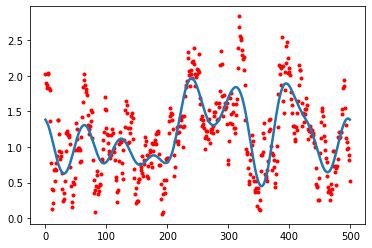

In [13]:
t = np.arange(len(Ztrain))[:, None]
lengthscale = float(t.max() - t.min())

# fig, ax = plt.subplots(1,1, figsize=(8, 8))

z = Ztrain[:, None]
zscaler = NormalScaler(data=z) 
zscaled = zscaler.transform(z)
#regression = GLMDense([FourierFeatures(dim=1, n_frequencies=10, lengthscale=lengthscale), PolyFeatures(dim=1, max_degree=3)])
regression = GLMDense([FourierFeatures(dim=1, n_frequencies=10, lengthscale=lengthscale),])
w_ls = regression.lstsq_solve(t, zscaled)
Phi = regression._get_design_matrix(t)
zscaled_pred = tf.matmul(Phi, w_ls)
z_pred = zscaler.inverse_transform(zscaled_pred)
plt.plot(t, z, 'r.', )
plt.plot(t, z_pred, linewidth=2.5 )

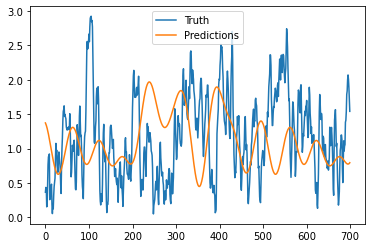

In [16]:
t_predict = np.arange(500, 500+700)[:, None]
Phi_predict = regression._get_design_matrix(t_predict)
z_predict = tf.matmul(Phi_predict, w_ls).numpy()
z_predict = zscaler.inverse_transform(z_predict)
plt.plot(Ztest)
plt.plot(z_predict[:,0])
plt.legend(['Truth', 'Predictions'])

In [17]:
def get_model(input_shape, max_poly_degree=3, n_frequencies=2, l1=1e-3):
    x = tfk.layers.Input(input_shape)
    y_poly = PolynomialDense(max_poly_degree=max_poly_degree, kernel_regularizer=tfk.regularizers.l1(l1))(x)
    if n_frequencies == 0:
        y_fourier = tfk.layers.Lambda(lambda x : tf.zeros_like(x))(x)
    else:
        y_fourier = FourierDense(n_frequencies=n_frequencies, kernel_regularizer=tfk.regularizers.l1(l1))(x)
    y = tfk.layers.Add()([y_poly, y_fourier])
    model = tfk.Model(x, y) 
    return model

In [18]:
z = Ztrain[:][:, None]
zscaler = NormalScaler(data=z) 
zscaled = zscaler.transform(z)
regression = GLMDense([FourierFeatures(dim=1, n_frequencies=15, lengthscale=lengthscale), PolyFeatures(dim=1, max_degree=3)])
w_ls = regression.lstsq_solve(t, zscaled)
t = tf.cast(t, tf.float32)
with tf.GradientTape() as tape:
    tape.watch(t)
    Phi = regression._get_design_matrix(t)
    zscaled_pred = tf.matmul(Phi, w_ls)
    z_pred = zscaler.inverse_transform(zscaled_pred)
dzdata = tape.gradient(z_pred, t)
zdata = z_pred
print(zdata.shape, dzdata.shape)

(500, 1) (500, 1)


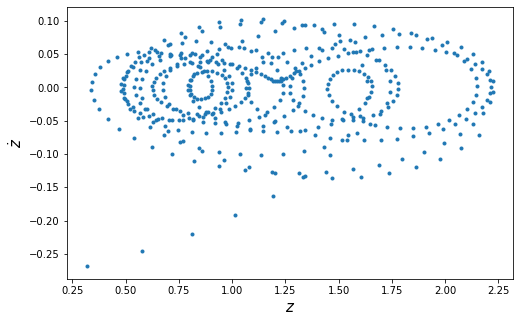

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(zdata, dzdata, '.')
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$\dot{z}$', fontsize=15);

In [20]:
print(zdata.shape, dzdata.shape)


# tfk.backend.clear_session()

# dzdata = tf.concat(list(dzdata.values()), axis=1)[:, :4]
# zdata = tf.concat(list(zdata.values()), axis=1)[:, :4]

# scale data 
zscaler = NormalScaler(data=zdata) 
zscaled = zscaler.transform(zdata)
dzscaler = NormalScaler(dzdata)
dz_scaled = dzscaler.transform(dzdata)

# set up training data 
train_dataset = tf.data.Dataset.from_tensor_slices((zscaled, dz_scaled))

# instantiate model
model = get_model((zdata.shape[1],), max_poly_degree=5, n_frequencies=3, l1=1e-4) # this is SINDy approximation of the dynamical system RHS 

# compile model
callbacks = [tfk.callbacks.ReduceLROnPlateau('loss', factor=0.1, patience=100, min_lr=1e-7), tfk.callbacks.ModelCheckpoint('model.h5', 'loss', save_best_only=True, save_weights_only=True)]
model.compile(optimizer=tfk.optimizers.Adam(1e-3), loss=tfk.losses.MeanSquaredError())

# fit model
batchsize = 32
epochs = 1000
model.fit(train_dataset.batch(batchsize), epochs=epochs, callbacks=callbacks)
model.load_weights("model.h5")

(500, 1) (500, 1)
Epoch 1/1000
16/16 [==============================] - 0s 855us/step - loss: 44.0991 - lr: 0.0010
Epoch 2/1000
16/16 [==============================] - 0s 759us/step - loss: 42.1124 - lr: 0.0010
Epoch 3/1000
16/16 [==============================] - 0s 689us/step - loss: 40.2162 - lr: 0.0010
Epoch 4/1000
16/16 [==============================] - 0s 631us/step - loss: 38.3891 - lr: 0.0010
Epoch 5/1000
16/16 [==============================] - 0s 687us/step - loss: 36.6307 - lr: 0.0010
Epoch 6/1000
16/16 [==============================] - 0s 610us/step - loss: 34.9398 - lr: 0.0010
Epoch 7/1000
16/16 [==============================] - 0s 549us/step - loss: 33.3148 - lr: 0.0010
Epoch 8/1000
16/16 [==============================] - 0s 606us/step - loss: 31.7543 - lr: 0.0010
Epoch 9/1000
16/16 [==============================] - 0s 532us/step - loss: 30.2566 - lr: 0.0010
Epoch 10/1000
16/16 [==============================] - 0s 567us/step - loss: 28.8201 - lr: 0.0010
Epoch 11/10

2022-09-22 12:14:57.558906: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 0s 578us/step - loss: 23.6533 - lr: 0.0010
Epoch 15/1000
16/16 [==============================] - 0s 582us/step - loss: 22.4984 - lr: 0.0010
Epoch 16/1000
16/16 [==============================] - 0s 506us/step - loss: 21.3951 - lr: 0.0010
Epoch 17/1000
16/16 [==============================] - 0s 519us/step - loss: 20.3417 - lr: 0.0010
Epoch 18/1000
16/16 [==============================] - 0s 562us/step - loss: 19.3367 - lr: 0.0010
Epoch 19/1000
16/16 [==============================] - 0s 519us/step - loss: 18.3786 - lr: 0.0010
Epoch 20/1000
16/16 [==============================] - 0s 546us/step - loss: 17.4658 - lr: 0.0010
Epoch 21/1000
16/16 [==============================] - 0s 577us/step - loss: 16.5969 - lr: 0.0010
Epoch 22/1000
16/16 [==============================] - 0s 543us/step - loss: 15.7703 - lr: 0.0010
Epoch 23/1000
16/16 [==============================] - 0s 547us/step - loss: 14.9846 - lr: 0.0010
Epoch 24/1000
16/16 [=============

16/16 [==============================] - 0s 517us/step - loss: 2.3939 - lr: 0.0010
Epoch 99/1000
16/16 [==============================] - 0s 582us/step - loss: 2.3801 - lr: 0.0010
Epoch 100/1000
16/16 [==============================] - 0s 509us/step - loss: 2.3664 - lr: 0.0010
Epoch 101/1000
16/16 [==============================] - 0s 548us/step - loss: 2.3529 - lr: 0.0010
Epoch 102/1000
16/16 [==============================] - 0s 520us/step - loss: 2.3396 - lr: 0.0010
Epoch 103/1000
16/16 [==============================] - 0s 523us/step - loss: 2.3264 - lr: 0.0010
Epoch 104/1000
16/16 [==============================] - 0s 544us/step - loss: 2.3134 - lr: 0.0010
Epoch 105/1000
16/16 [==============================] - 0s 532us/step - loss: 2.3005 - lr: 0.0010
Epoch 106/1000
16/16 [==============================] - 0s 570us/step - loss: 2.2877 - lr: 0.0010
Epoch 107/1000
16/16 [==============================] - 0s 534us/step - loss: 2.2751 - lr: 0.0010
Epoch 108/1000
16/16 [==============

16/16 [==============================] - 0s 599us/step - loss: 1.6126 - lr: 0.0010
Epoch 182/1000
16/16 [==============================] - 0s 561us/step - loss: 1.6066 - lr: 0.0010
Epoch 183/1000
16/16 [==============================] - 0s 617us/step - loss: 1.6006 - lr: 0.0010
Epoch 184/1000
16/16 [==============================] - 0s 563us/step - loss: 1.5947 - lr: 0.0010
Epoch 185/1000
16/16 [==============================] - 0s 561us/step - loss: 1.5889 - lr: 0.0010
Epoch 186/1000
16/16 [==============================] - 0s 586us/step - loss: 1.5831 - lr: 0.0010
Epoch 187/1000
16/16 [==============================] - 0s 538us/step - loss: 1.5774 - lr: 0.0010
Epoch 188/1000
16/16 [==============================] - 0s 573us/step - loss: 1.5717 - lr: 0.0010
Epoch 189/1000
16/16 [==============================] - 0s 523us/step - loss: 1.5661 - lr: 0.0010
Epoch 190/1000
16/16 [==============================] - 0s 524us/step - loss: 1.5606 - lr: 0.0010
Epoch 191/1000
16/16 [=============

16/16 [==============================] - 0s 571us/step - loss: 1.2809 - lr: 0.0010
Epoch 265/1000
16/16 [==============================] - 0s 523us/step - loss: 1.2785 - lr: 0.0010
Epoch 266/1000
16/16 [==============================] - 0s 543us/step - loss: 1.2761 - lr: 0.0010
Epoch 267/1000
16/16 [==============================] - 0s 531us/step - loss: 1.2737 - lr: 0.0010
Epoch 268/1000
16/16 [==============================] - 0s 489us/step - loss: 1.2714 - lr: 0.0010
Epoch 269/1000
16/16 [==============================] - 0s 1ms/step - loss: 1.2691 - lr: 0.0010
Epoch 270/1000
16/16 [==============================] - 0s 490us/step - loss: 1.2668 - lr: 0.0010
Epoch 271/1000
16/16 [==============================] - 0s 488us/step - loss: 1.2646 - lr: 0.0010
Epoch 272/1000
16/16 [==============================] - 0s 516us/step - loss: 1.2624 - lr: 0.0010
Epoch 273/1000
16/16 [==============================] - 0s 570us/step - loss: 1.2602 - lr: 0.0010
Epoch 274/1000
16/16 [===============

Epoch 348/1000
16/16 [==============================] - 0s 493us/step - loss: 1.1506 - lr: 0.0010
Epoch 349/1000
16/16 [==============================] - 0s 464us/step - loss: 1.1497 - lr: 0.0010
Epoch 350/1000
16/16 [==============================] - 0s 516us/step - loss: 1.1488 - lr: 0.0010
Epoch 351/1000
16/16 [==============================] - 0s 524us/step - loss: 1.1479 - lr: 0.0010
Epoch 352/1000
16/16 [==============================] - 0s 478us/step - loss: 1.1470 - lr: 0.0010
Epoch 353/1000
16/16 [==============================] - 0s 509us/step - loss: 1.1461 - lr: 0.0010
Epoch 354/1000
16/16 [==============================] - 0s 518us/step - loss: 1.1453 - lr: 0.0010
Epoch 355/1000
16/16 [==============================] - 0s 535us/step - loss: 1.1444 - lr: 0.0010
Epoch 356/1000
16/16 [==============================] - 0s 494us/step - loss: 1.1436 - lr: 0.0010
Epoch 357/1000
16/16 [==============================] - 0s 456us/step - loss: 1.1427 - lr: 0.0010
Epoch 358/1000
16/16

16/16 [==============================] - 0s 520us/step - loss: 1.0977 - lr: 0.0010
Epoch 432/1000
16/16 [==============================] - 0s 572us/step - loss: 1.0973 - lr: 0.0010
Epoch 433/1000
16/16 [==============================] - 0s 515us/step - loss: 1.0968 - lr: 0.0010
Epoch 434/1000
16/16 [==============================] - 0s 523us/step - loss: 1.0964 - lr: 0.0010
Epoch 435/1000
16/16 [==============================] - 0s 501us/step - loss: 1.0959 - lr: 0.0010
Epoch 436/1000
16/16 [==============================] - 0s 496us/step - loss: 1.0955 - lr: 0.0010
Epoch 437/1000
16/16 [==============================] - 0s 529us/step - loss: 1.0951 - lr: 0.0010
Epoch 438/1000
16/16 [==============================] - 0s 520us/step - loss: 1.0946 - lr: 0.0010
Epoch 439/1000
16/16 [==============================] - 0s 509us/step - loss: 1.0942 - lr: 0.0010
Epoch 440/1000
16/16 [==============================] - 0s 515us/step - loss: 1.0938 - lr: 0.0010
Epoch 441/1000
16/16 [=============

16/16 [==============================] - 0s 553us/step - loss: 1.0667 - lr: 0.0010
Epoch 515/1000
16/16 [==============================] - 0s 544us/step - loss: 1.0664 - lr: 0.0010
Epoch 516/1000
16/16 [==============================] - 0s 498us/step - loss: 1.0661 - lr: 0.0010
Epoch 517/1000
16/16 [==============================] - 0s 534us/step - loss: 1.0658 - lr: 0.0010
Epoch 518/1000
16/16 [==============================] - 0s 487us/step - loss: 1.0655 - lr: 0.0010
Epoch 519/1000
16/16 [==============================] - 0s 521us/step - loss: 1.0652 - lr: 0.0010
Epoch 520/1000
16/16 [==============================] - 0s 452us/step - loss: 1.0649 - lr: 0.0010
Epoch 521/1000
16/16 [==============================] - 0s 487us/step - loss: 1.0646 - lr: 0.0010
Epoch 522/1000
16/16 [==============================] - 0s 525us/step - loss: 1.0643 - lr: 0.0010
Epoch 523/1000
16/16 [==============================] - 0s 512us/step - loss: 1.0640 - lr: 0.0010
Epoch 524/1000
16/16 [=============

16/16 [==============================] - 0s 558us/step - loss: 1.0445 - lr: 0.0010
Epoch 598/1000
16/16 [==============================] - 0s 513us/step - loss: 1.0442 - lr: 0.0010
Epoch 599/1000
16/16 [==============================] - 0s 537us/step - loss: 1.0440 - lr: 0.0010
Epoch 600/1000
16/16 [==============================] - 0s 534us/step - loss: 1.0438 - lr: 0.0010
Epoch 601/1000
16/16 [==============================] - 0s 558us/step - loss: 1.0436 - lr: 0.0010
Epoch 602/1000
16/16 [==============================] - 0s 530us/step - loss: 1.0433 - lr: 0.0010
Epoch 603/1000
16/16 [==============================] - 0s 548us/step - loss: 1.0431 - lr: 0.0010
Epoch 604/1000
16/16 [==============================] - 0s 538us/step - loss: 1.0429 - lr: 0.0010
Epoch 605/1000
16/16 [==============================] - 0s 536us/step - loss: 1.0427 - lr: 0.0010
Epoch 606/1000
16/16 [==============================] - 0s 517us/step - loss: 1.0424 - lr: 0.0010
Epoch 607/1000
16/16 [=============

16/16 [==============================] - 0s 498us/step - loss: 1.0285 - lr: 0.0010
Epoch 681/1000
16/16 [==============================] - 0s 546us/step - loss: 1.0283 - lr: 0.0010
Epoch 682/1000
16/16 [==============================] - 0s 512us/step - loss: 1.0282 - lr: 0.0010
Epoch 683/1000
16/16 [==============================] - 0s 537us/step - loss: 1.0280 - lr: 0.0010
Epoch 684/1000
16/16 [==============================] - 0s 474us/step - loss: 1.0279 - lr: 0.0010
Epoch 685/1000
16/16 [==============================] - 0s 536us/step - loss: 1.0277 - lr: 0.0010
Epoch 686/1000
16/16 [==============================] - 0s 552us/step - loss: 1.0275 - lr: 0.0010
Epoch 687/1000
16/16 [==============================] - 0s 537us/step - loss: 1.0274 - lr: 0.0010
Epoch 688/1000
16/16 [==============================] - 0s 506us/step - loss: 1.0272 - lr: 0.0010
Epoch 689/1000
16/16 [==============================] - 0s 544us/step - loss: 1.0271 - lr: 0.0010
Epoch 690/1000
16/16 [=============

16/16 [==============================] - 0s 558us/step - loss: 1.0174 - lr: 0.0010
Epoch 764/1000
16/16 [==============================] - 0s 492us/step - loss: 1.0172 - lr: 0.0010
Epoch 765/1000
16/16 [==============================] - 0s 482us/step - loss: 1.0171 - lr: 0.0010
Epoch 766/1000
16/16 [==============================] - 0s 490us/step - loss: 1.0170 - lr: 0.0010
Epoch 767/1000
16/16 [==============================] - 0s 544us/step - loss: 1.0169 - lr: 0.0010
Epoch 768/1000
16/16 [==============================] - 0s 509us/step - loss: 1.0168 - lr: 0.0010
Epoch 769/1000
16/16 [==============================] - 0s 466us/step - loss: 1.0167 - lr: 0.0010
Epoch 770/1000
16/16 [==============================] - 0s 525us/step - loss: 1.0166 - lr: 0.0010
Epoch 771/1000
16/16 [==============================] - 0s 616us/step - loss: 1.0165 - lr: 0.0010
Epoch 772/1000
16/16 [==============================] - 0s 604us/step - loss: 1.0164 - lr: 0.0010
Epoch 773/1000
16/16 [=============

16/16 [==============================] - 0s 542us/step - loss: 1.0097 - lr: 0.0010
Epoch 847/1000
16/16 [==============================] - 0s 549us/step - loss: 1.0096 - lr: 0.0010
Epoch 848/1000
16/16 [==============================] - 0s 528us/step - loss: 1.0096 - lr: 0.0010
Epoch 849/1000
16/16 [==============================] - 0s 524us/step - loss: 1.0095 - lr: 0.0010
Epoch 850/1000
16/16 [==============================] - 0s 516us/step - loss: 1.0094 - lr: 0.0010
Epoch 851/1000
16/16 [==============================] - 0s 574us/step - loss: 1.0093 - lr: 0.0010
Epoch 852/1000
16/16 [==============================] - 0s 542us/step - loss: 1.0093 - lr: 0.0010
Epoch 853/1000
16/16 [==============================] - 0s 557us/step - loss: 1.0092 - lr: 0.0010
Epoch 854/1000
16/16 [==============================] - 0s 541us/step - loss: 1.0091 - lr: 0.0010
Epoch 855/1000
16/16 [==============================] - 0s 549us/step - loss: 1.0090 - lr: 0.0010
Epoch 856/1000
16/16 [=============

16/16 [==============================] - 0s 612us/step - loss: 1.0045 - lr: 0.0010
Epoch 930/1000
16/16 [==============================] - 0s 587us/step - loss: 1.0045 - lr: 0.0010
Epoch 931/1000
16/16 [==============================] - 0s 677us/step - loss: 1.0044 - lr: 0.0010
Epoch 932/1000
16/16 [==============================] - 0s 685us/step - loss: 1.0044 - lr: 0.0010
Epoch 933/1000
16/16 [==============================] - 0s 668us/step - loss: 1.0043 - lr: 0.0010
Epoch 934/1000
16/16 [==============================] - 0s 613us/step - loss: 1.0043 - lr: 0.0010
Epoch 935/1000
16/16 [==============================] - 0s 503us/step - loss: 1.0042 - lr: 0.0010
Epoch 936/1000
16/16 [==============================] - 0s 566us/step - loss: 1.0042 - lr: 0.0010
Epoch 937/1000
16/16 [==============================] - 0s 596us/step - loss: 1.0041 - lr: 0.0010
Epoch 938/1000
16/16 [==============================] - 0s 518us/step - loss: 1.0041 - lr: 0.0010
Epoch 939/1000
16/16 [=============

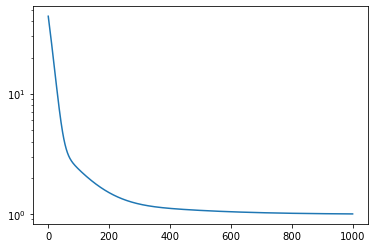

In [21]:
plt.semilogy(model.history.history['loss'])

In [22]:
from scipy.integrate import odeint, RK45

def rhs(t, z):
    z = zscaler.transform(z[None, :])
    dz = model.predict(z)
    dz = dzscaler.inverse_transform(dz)
    return dz[0]

dt = 0.5
z0 = zdata[0].numpy()
integrator = RK45(fun=rhs, t0=0.0, y0=z0, t_bound=forecast_period, max_step=dt)
z_preds = [z0,]
t_preds = [0.,]
while integrator.status == 'running':
    integrator.step()
    z_next = integrator.y
    t_next = integrator.t
    z_preds.append(z_next)
    t_preds.append(t_next)

    if (len(t_preds)+1) % 50 == 0:
        print(f"Time = {t_next}")

t_preds = np.hstack(t_preds)
z_preds = np.vstack(z_preds)

NameError: name 'forecast_period' is not defined